In [220]:
import pandas as pd
import numpy as np
import random
from IPython.display import display

import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset

In [17]:
events_df = pd.read_csv('../data/run_events.csv')
events_df.head()

,NRUN,NEvent,Theta,Phi,event_time_ns,clusters_bit,clusters,1_1_t,1_2_t,1_3_t,...,8_theta,8_phi,8_a_x,8_a_y,8_a_z,9_theta,9_phi,9_a_x,9_a_y,9_a_z
0,836,6627,63.67,116.71,41539852841490,254,"7,2,5,3,4,8,6",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,836,12188,42.90,198.78,41927414340004,348,"9,3,7,4,5",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.897595,190.808834,-0.916387,-0.174957,0.360036
2,836,12453,51.32,212.71,41946132622518,151,"1,3,2,8,5",2376.449,2347.995,2335.962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,836,31010,44.25,234.01,43256194340235,44,"6,3,4",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,836,71181,41.01,139.26,46120750960920,447,"2,1,3,9,5,4,6,8",2352.727,2340.497,2355.610,...,41.388629,136.938436,-0.483059,0.451431,0.750242,40.300258,138.166407,-0.481916,0.431391,0.762665


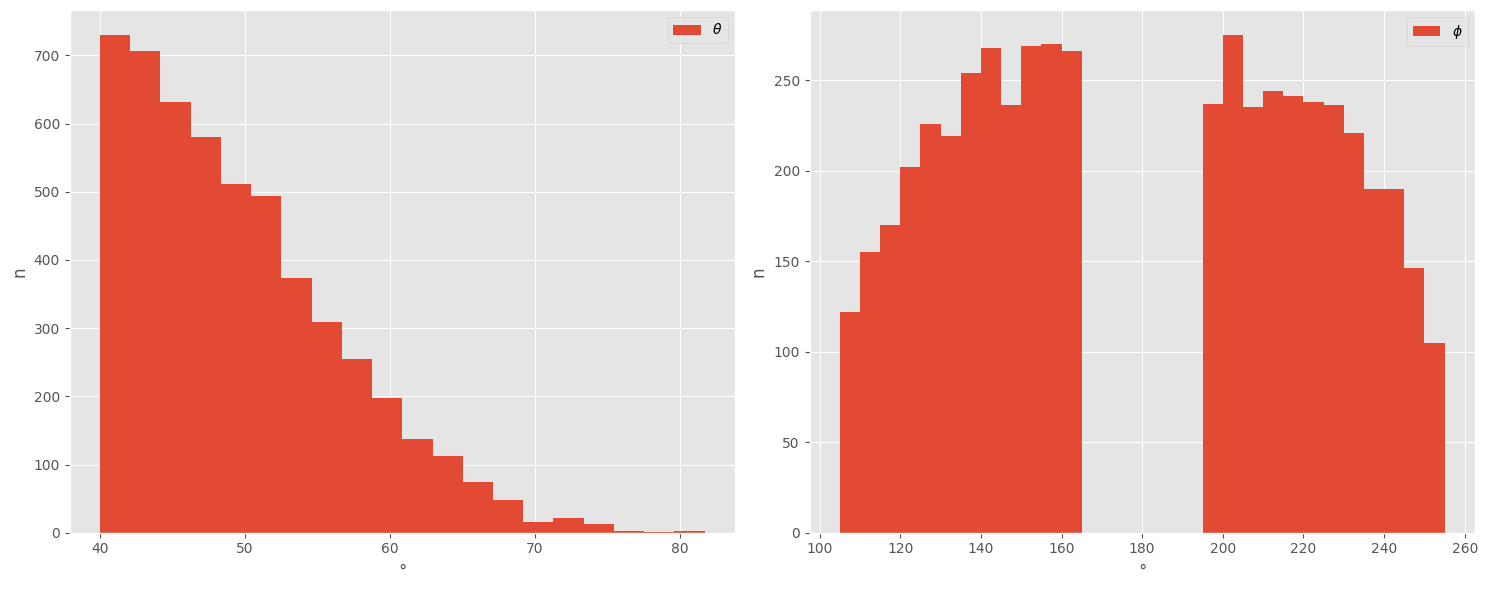

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(events_df['Theta'], bins=20, label=r'$\theta$')
ax1.set_xlabel(r'$\degree$')
ax1.set_ylabel('n')
ax1.legend()
ax1.grid(True)

ax2.hist(events_df['Phi'], bins=30, label=r"$\phi$")
ax2.set_xlabel(r'$\degree$')
ax2.set_ylabel('n')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [33]:
phi_list = list(range(100, 171)) + list(range(190, 261))
theta_list = list(range(35, 86))

In [8]:
coordinates_df = pd.read_csv('../data/coordinates.csv')

In [9]:
coordinates_df.head()

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684
2,1,1.3,-37.609,-7.315,-6.684
3,1,1.4,-25.359,-7.315,-6.684
4,2,2.1,-25.359,37.335,-6.684


In [ ]:
import numpy as np
import pandas as pd


def calculate_relative_times(theta_deg, phi_deg, coordinates_df):
    """
    Рассчитывает относительное время срабатывания станций для заданных углов θ и φ.

    Parameters:
    -----------
    theta_deg : float
        Зенитный угол (в градусах).
    phi_deg : float
        Азимутальный угол (в градусах).
    coordinates_df : pd.DataFrame
        Таблица с координатами станций, содержащая столбцы ['X', 'Y', 'Z'].

    Returns:
    --------
    pd.DataFrame
        Исходная таблица с добавленными столбцами:
        - 'time': время срабатывания станции.
        - 'relative_time': время, нормированное относительно первой сработавшей станции.
    """
    C = 299792458e-9

    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)

    v = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])

    coordinates_df = coordinates_df.copy()
    coordinates_df["time"] = -(coordinates_df[["X", "Y", "Z"]].values @ v) / C

    coordinates_df["relative_time"] = coordinates_df["time"] - \
        coordinates_df["time"].min()

    return coordinates_df

In [ ]:
def calculate_relative_times(theta_deg, phi_deg, coordinates_df):
    """
    Рассчитывает относительное время срабатывания станций для заданных углов θ и φ.

    Parameters:
    -----------
    theta_deg : float
        Зенитный угол (в градусах).
    phi_deg : float
        Азимутальный угол (в градусах).
    coordinates_df : pd.DataFrame
        Таблица с координатами станций, содержащая столбцы ['X', 'Y', 'Z'].

    Returns:
    --------
    list
        Список вида [(x1, y1, z1, t1), (x2, y2, z2, t2), ...] для всех станций,
        отсортированный по времени срабатывания.
    """
    C = 299792458e-9

    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)

    v = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])

    coordinates_df = coordinates_df.copy()
    coordinates_df["time"] = -(coordinates_df[["X", "Y", "Z"]].values @ v) / C

    coordinates_df["relative_time"] = coordinates_df["time"] - \
        coordinates_df["time"].min()

    coordinates_df = coordinates_df.sort_values("relative_time")

    sequence = [
        (row.X, row.Y, row.Z, row.relative_time)
        for row in coordinates_df.itertuples()
    ]
    return sequence

In [216]:
def generate_dataset(theta_list, phi_list, coordinates_df):
    dataset = []

    for theta in theta_list:
        for phi in phi_list:
            sequence = calculate_relative_times(theta, phi, coordinates_df)
            vector = []
            for idx, row in sequence.iterrows():

                vector.append(float(row["X"]))
                vector.append(float(row["Y"]))
                vector.append(float(row["Z"]))
                vector.append(float(row["relative_time"]))

            vector.append(theta)
            vector.append(phi)

            dataset.extend([vector])

    columns_names = [item for i in range(1, 37) for item in [f'X_{i}', f'Y_{i}', f'Z_{
        i}', f't_{i}']] + ['theta', 'phi']

    dataset_df = pd.DataFrame(
        dataset,
        columns=columns_names
    )

    return dataset_df

In [232]:
def generate_dataset(theta_list, phi_list, coordinates_df):
    dataset = []

    for theta in theta_list:
        for phi in phi_list:
            sequence = calculate_relative_times(theta, phi, coordinates_df)
            vector = []
            for idx, row in sequence.iterrows():
                vector.append(float(row["X"]))
                vector.append(float(row["Y"]))
                vector.append(float(row["Z"]))
                vector.append(float(row["relative_time"]))
                if len(vector) == 16:
                    vector.append(theta)
                    vector.append(phi)
                    dataset.extend([vector])
                    vector = []

    columns_names = [item for i in range(1, 5) for item in [f'X_{i}', f'Y_{i}', f'Z_{
        i}', f't_{i}']] + ['theta', 'phi']

    dataset_df = pd.DataFrame(
        dataset,
        columns=columns_names,
    )

    return dataset_df

In [233]:
my_dataset = generate_dataset(theta_list, phi_list, coordinates_df)

In [234]:
my_dataset.head(15)

,X_1,Y_1,Z_1,t_1,X_2,Y_2,Z_2,t_2,X_3,Y_3,Z_3,t_3,X_4,Y_4,Z_4,t_4,theta,phi
0,-25.359,5.885,-6.684,78.875263,-37.609,5.885,-6.684,74.805427,-37.609,-7.315,-6.684,99.676584,-25.359,-7.315,-6.684,103.746420,35,100
1,-25.359,37.335,-6.684,19.617847,-37.609,37.335,-6.684,15.548011,-37.609,24.135,-6.684,40.419168,-25.359,24.135,-6.684,44.489004,35,100
2,6.479,12.650,0.000,58.443040,-6.872,12.650,0.000,54.007417,-6.872,-12.630,0.000,101.639451,6.479,-12.630,0.000,106.075074,35,100
3,37.369,10.956,-14.946,112.735877,22.469,10.956,-15.266,108.659994,22.469,-3.952,-15.346,136.967920,37.369,-3.952,-15.076,141.180423,35,100
4,37.369,45.572,-16.166,50.846676,22.977,45.572,-16.461,46.871258,22.977,28.482,-16.111,78.115530,37.367,28.482,-16.511,83.989301,35,100
5,6.915,-56.160,-16.151,232.369165,-2.794,-56.160,-15.911,228.487754,-2.794,-70.539,-15.931,255.635005,6.915,-70.539,-16.101,259.325149,35,100
6,-9.541,53.623,-17.031,22.455698,-20.557,64.708,-17.796,0.000000,-20.557,53.623,-17.501,20.080062,-9.541,42.539,-16.931,43.066693,35,100
7,42.140,-16.802,-15.136,167.141137,26.940,-16.802,-15.456,162.965585,26.940,-32.102,-15.456,191.793517,42.140,-32.102,-14.686,194.739491,35,100
8,-25.359,-25.745,-7.329,140.234227,-37.255,-25.745,-7.364,136.377635,-37.255,-39.545,-7.339,162.310989,-25.359,-39.545,-7.279,166.099271,35,100
9,-25.359,5.885,-6.684,78.359649,-37.609,5.885,-6.684,73.887611,-37.609,-7.315,-6.684,98.678443,-25.359,-7.315,-6.684,103.150482,35,101


In [ ]:
my_dataset.to_csv('../data/clusters_synthetic_dataset.csv', index=False)

: 

In [56]:
my_dataset.head(2)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 15.548011244520737]","[-25.359, 37.335, -6.684, 19.61784732035651]","[-20.557, 53.623, -17.501, 20.080062178745713]","[-9.541, 53.623, -17.031, 22.45569792408036]","[-37.609, 24.135, -6.684, 40.4191682211243]","[-9.541, 42.539, -16.931, 43.06669335970904]","[-25.359, 24.135, -6.684, 44.489004296960054]","[22.977, 45.572, -16.461, 46.871257601621416]","[37.369, 45.572, -16.166, 50.84667643964997]",...,"[-25.359, -39.545, -7.279, 166.09927120085757]","[42.14, -16.802, -15.136, 167.14113741508186]","[26.94, -32.102, -15.456, 191.79351738958118]","[42.14, -32.102, -14.686, 194.73949066806261]","[-2.794, -56.16, -15.911, 228.48775393221587]","[6.915, -56.16, -16.151, 232.3691650300517]","[-2.794, -70.539, -15.931, 255.6350053717809]","[6.915, -70.539, -16.101, 259.3251486722786]",35,100
1,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 14.821575068860497]","[-25.359, 37.335, -6.684, 19.29361355156165]","[-20.557, 53.623, -17.501, 20.012607637245324]","[-9.541, 53.623, -17.031, 22.74993005311297]","[-37.609, 24.135, -6.684, 39.612407286979135]","[-9.541, 42.539, -16.931, 43.29347703245022]","[-25.359, 24.135, -6.684, 44.08444576968031]","[22.977, 45.572, -16.461, 48.184156314529986]","[37.369, 45.572, -16.166, 52.632105523138705]",...,"[-25.359, -39.545, -7.279, 165.30720656597785]","[42.14, -16.802, -15.136, 168.70365319904894]","[26.94, -32.102, -15.456, 192.76387016320496]","[42.14, -32.102, -14.686, 196.20890275469486]","[-2.794, -56.16, -15.911, 228.33545680006858]","[6.915, -56.16, -16.151, 232.5356420340886]","[-2.794, -70.539, -15.931, 255.3952090197658]","[6.915, -70.539, -16.101, 259.4041264564477]",35,101


# NN

In [ ]:
def prepare_data(dataset_df):
    """
    Функция для подготовки данных для нейросети. Преобразует столбцы с последовательностями в векторы и
    нормализует данные, возвращая тензоры для входных данных и целевых значений.

    :param dataset_df: pandas DataFrame, где первые 37 столбцов содержат последовательности [X, Y, Z, relative_time],
                        а последние два столбца содержат значения theta и phi.

    :return: (X_tensor, y_tensor) - тензоры для входных данных и целевых значений.
    """
    X = []
    y = []

    for i, row in dataset_df.iterrows():
        sequence = row[:37]
        target = [row[36], row[37]]
        X_row = []
        for vector in sequence:
            if isinstance(vector, str):
                vector = eval(vector)
            if isinstance(vector, list):
                X_row.extend(vector)
            else:
                X_row.append(vector)

        X.append(X_row)
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    return X_tensor, y_tensor

In [72]:
X_tensor, y_tensor = prepare_data(my_dataset)

In [74]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(NeuralNetwork, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [77]:
input_size = X_tensor.shape[1]
model = NeuralNetwork(input_size).to(device)

print(model)

NeuralNetwork(
  (fc1): Linear(in_features=145, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


In [78]:
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

In [86]:
batch_size = 16
epochs = 10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [95]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [96]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            pbar.set_postfix(loss=running_loss / (pbar.n + 1))

        print(
            f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader)}")

print("Обучение завершено.")

Epoch 1/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [1/10], Loss: 0.7243929308849376


Epoch 2/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [2/10], Loss: 0.48771028675057077


Epoch 3/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [3/10], Loss: 0.6454420246920742


Epoch 4/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [4/10], Loss: 0.559744482593877


Epoch 5/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [5/10], Loss: 0.4103997802095754


Epoch 6/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [6/10], Loss: 0.8766812687064265


Epoch 7/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [7/10], Loss: 0.8165559835609172


Epoch 8/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [8/10], Loss: 0.4945490743432726


Epoch 9/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [9/10], Loss: 0.48016949165817147


Epoch 10/10:   0%|          | 0/182 [00:00<?, ?batch/s]

Epoch [10/10], Loss: 0.4495778248369039
Обучение завершено.


In [97]:
model.eval()

predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        # Переносим данные на GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Получаем предсказания
        outputs = model(inputs)

        # Сохраняем предсказания и истинные значения
        predictions.append(outputs.cpu().numpy())
        true_values.append(targets.cpu().numpy())

predictions = np.vstack(predictions)
true_values = np.vstack(true_values)

In [98]:
print("Predictions (first 5):")
print(predictions[:5])

print("True values (first 5):")
print(true_values[:5])

Predictions (first 5):
[[ 37.73409  202.89476 ]
 [ 64.29947  131.45717 ]
 [ 59.911247 165.36913 ]
 [ 44.453316 159.11906 ]
 [ 55.633904 104.25806 ]]
True values (first 5):
[[ 38. 202.]
 [ 64. 130.]
 [ 61. 166.]
 [ 45. 160.]
 [ 56. 104.]]


# missing times

In [99]:
my_dataset.head(2)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 15.548011244520737]","[-25.359, 37.335, -6.684, 19.61784732035651]","[-20.557, 53.623, -17.501, 20.080062178745713]","[-9.541, 53.623, -17.031, 22.45569792408036]","[-37.609, 24.135, -6.684, 40.4191682211243]","[-9.541, 42.539, -16.931, 43.06669335970904]","[-25.359, 24.135, -6.684, 44.489004296960054]","[22.977, 45.572, -16.461, 46.871257601621416]","[37.369, 45.572, -16.166, 50.84667643964997]",...,"[-25.359, -39.545, -7.279, 166.09927120085757]","[42.14, -16.802, -15.136, 167.14113741508186]","[26.94, -32.102, -15.456, 191.79351738958118]","[42.14, -32.102, -14.686, 194.73949066806261]","[-2.794, -56.16, -15.911, 228.48775393221587]","[6.915, -56.16, -16.151, 232.3691650300517]","[-2.794, -70.539, -15.931, 255.6350053717809]","[6.915, -70.539, -16.101, 259.3251486722786]",35,100
1,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 14.821575068860497]","[-25.359, 37.335, -6.684, 19.29361355156165]","[-20.557, 53.623, -17.501, 20.012607637245324]","[-9.541, 53.623, -17.031, 22.74993005311297]","[-37.609, 24.135, -6.684, 39.612407286979135]","[-9.541, 42.539, -16.931, 43.29347703245022]","[-25.359, 24.135, -6.684, 44.08444576968031]","[22.977, 45.572, -16.461, 48.184156314529986]","[37.369, 45.572, -16.166, 52.632105523138705]",...,"[-25.359, -39.545, -7.279, 165.30720656597785]","[42.14, -16.802, -15.136, 168.70365319904894]","[26.94, -32.102, -15.456, 192.76387016320496]","[42.14, -32.102, -14.686, 196.20890275469486]","[-2.794, -56.16, -15.911, 228.33545680006858]","[6.915, -56.16, -16.151, 232.5356420340886]","[-2.794, -70.539, -15.931, 255.3952090197658]","[6.915, -70.539, -16.101, 259.4041264564477]",35,101


In [ ]:
def introduce_missing_times(dataset_df):
    """
    Функция модификации данных, где случайным образом оставляются None для времени в каждой строке,
    пропуски вводятся только в первые 36 столбцов, последние два столбца (theta и phi) остаются без изменений.
    После введения пропусков минимальное время среди оставшихся значений будет сделано равным 0, 
    а остальные будут приведены относительно минимального времени.

    :param dataset_df: pandas DataFrame, где первые 36 столбцов содержат координаты и время,
                        а последние два столбца - theta и phi.
    :return: модифицированный DataFrame с пропущенными значениями
    """
    # Определяем проценты
    missing_config = {
        33: 0.30,   # 30% строк будут иметь 3 пропуска
        32: 0.20,   # 20% строк будут иметь 4 пропуска
        31: 0.10,   # 10% строк будут иметь 5 пропусков
        30: 0.10,   # 10% строк будут иметь 6 пропусков
        29: 0.05,   # 5% строк будут иметь 7 пропусков
        28: 0.05,   # 5% строк будут иметь 8 пропусков
        27: 0.05,   # 5% строк будут иметь 9 пропусков
        26: 0.05,   # 5% строк будут иметь 10 пропусков
        25: 0.05,   # 5% строк будут иметь 11 пропусков
        24: 0.05    # 5% строк будут иметь 12 пропусков
    }

    time_columns = 36

    for i, row in dataset_df.iterrows():
        n_missing = random.choices(
            list(missing_config.keys()), list(missing_config.values()))[0]

        row_data = row[:time_columns].apply(
            lambda x: eval(x) if isinstance(x, str) else x)
        indices_to_mask = random.sample(range(time_columns), n_missing)

        for index in indices_to_mask:
            row_data[index] = None

        dataset_df.iloc[i, :time_columns] = row_data

        time_values = [x[3] for x in row_data if x is not None]

        if time_values:
            min_time = min(time_values)

            for index in range(time_columns):
                if row_data[index] is not None:
                    row_data[index][3] -= min_time

            dataset_df.iloc[i, :time_columns] = row_data

    return dataset_df

In [140]:
my_dataset = pd.read_csv('../data/my_dataset.csv')
my_dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 15.548011244520737]","[-25.359, 37.335, -6.684, 19.61784732035651]","[-20.557, 53.623, -17.501, 20.080062178745713]","[-9.541, 53.623, -17.031, 22.45569792408036]","[-37.609, 24.135, -6.684, 40.4191682211243]","[-9.541, 42.539, -16.931, 43.06669335970904]","[-25.359, 24.135, -6.684, 44.489004296960054]","[22.977, 45.572, -16.461, 46.871257601621416]","[37.369, 45.572, -16.166, 50.84667643964997]",...,"[-25.359, -39.545, -7.279, 166.09927120085757]","[42.14, -16.802, -15.136, 167.14113741508186]","[26.94, -32.102, -15.456, 191.79351738958118]","[42.14, -32.102, -14.686, 194.73949066806261]","[-2.794, -56.16, -15.911, 228.48775393221587]","[6.915, -56.16, -16.151, 232.3691650300517]","[-2.794, -70.539, -15.931, 255.6350053717809]","[6.915, -70.539, -16.101, 259.3251486722786]",35,100
1,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 14.821575068860497]","[-25.359, 37.335, -6.684, 19.29361355156165]","[-20.557, 53.623, -17.501, 20.012607637245324]","[-9.541, 53.623, -17.031, 22.74993005311297]","[-37.609, 24.135, -6.684, 39.612407286979135]","[-9.541, 42.539, -16.931, 43.29347703245022]","[-25.359, 24.135, -6.684, 44.08444576968031]","[22.977, 45.572, -16.461, 48.184156314529986]","[37.369, 45.572, -16.166, 52.632105523138705]",...,"[-25.359, -39.545, -7.279, 165.30720656597785]","[42.14, -16.802, -15.136, 168.70365319904894]","[26.94, -32.102, -15.456, 192.76387016320496]","[42.14, -32.102, -14.686, 196.20890275469486]","[-2.794, -56.16, -15.911, 228.33545680006858]","[6.915, -56.16, -16.151, 232.5356420340886]","[-2.794, -70.539, -15.931, 255.3952090197658]","[6.915, -70.539, -16.101, 259.4041264564477]",35,101
2,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 14.081375417714156]","[-25.359, 37.335, -6.684, 18.954254081037263]","[-20.557, 53.623, -17.501, 19.938811528777016]","[-9.541, 53.623, -17.031, 23.03659561237785]","[-37.609, 24.135, -6.684, 38.78433134970005]","[-9.541, 42.539, -16.931, 43.506353140541215]","[-25.359, 24.135, -6.684, 43.65721001302317]","[22.977, 45.572, -16.461, 49.48126652662707]","[-6.872, 12.65, 0.0, 54.24118088970229]",...,"[26.94, -16.802, -15.456, 165.04058592996506]","[42.14, -16.802, -15.136, 170.21256625907353]","[26.94, -32.102, -15.456, 193.67355757840323]","[42.14, -32.102, -14.686, 197.61595921033836]","[-2.794, -56.16, -15.911, 228.11203756277197]","[6.915, -56.16, -16.151, 232.62991727137637]","[-2.794, -70.539, -15.931, 255.07606454623416]","[6.915, -70.539, -16.101, 259.40267645750043]",35,102
3,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 13.327637763065908]","[-25.359, 37.335, -6.684, 18.599872280965513]","[-20.557, 53.623, -17.501, 19.858696332350355]","[-9.541, 53.623, -17.031, 23.31560728076869]","[-37.609, 24.135, -6.684, 37.93519264923926]","[-25.359, 24.135, -6.684, 43.20742716713887]","[-9.541, 42.539, -16.931, 43.70525683985734]","[22.977, 45.572, -16.461, 50.76219312557668]","[-6.872, 12.65, 0.0, 54.31107694200139]",...,"[26.94, -16.802, -15.456, 165.99990937205786]","[42.14, -16.802, -15.136, 171.66741696562042]","[26.94, -32.102, -15.456, 194.52230253557696]","[42.14, -32.102, -14.686, 198.96023143196615]","[-2.794, -56.16, -15.911, 227.81756427599004]","[6.915, -56.16, -16.151, 232.65196202476443]","[-2.794, -70.539, -15.931, 254.6776691656841]","[6.915, -70.539, -16.101, 259.32079911712043]",35,103
4,"[-20.557, 64.708, -17.796, 0.0]","[-37.609, 37.335, -6.684, 12.56059170070705]","[-25.359, 37.335, -6.684, 18.23057609947569]","[-20.557, 53.623, -17.501, 19.77228645183026]","[-9.541, 53.623, -17.031, 23.586880068628474]","[-37.609, 24.135, -6.684, 37.0652498414708]","[-25.359, 24.135, -6.684, 42.73523424023946]","[-9.541, 42.539, -16.931, 43.890127542405004]","[22.977, 45.572, -16.461, 52.02654592872823]","[-6.872, 12.65, 0.0, 54.34961744303058]",...,"[26.94, -16.802, -15.456, 166.90672001745048]","[42.14, -16.802,

In [137]:
my_dataset1 = introduce_missing_times(my_dataset)

C:\Users\matsvei\AppData\Local\Temp\ipykernel_14144\44282804.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row_data[index] = None
C:\Users\matsvei\AppData\Local\Temp\ipykernel_14144\44282804.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row_data[index] = None
C:\Users\matsvei\AppData\Local\Temp\ipykernel_14144\44282804.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row_data[index] = None
C:\Users\m

In [191]:
my_dataset1.head(10)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,"[-6.872, 12.65, 0.0, 0.0]","[-25.359, -25.745, -7.329, 86.2268101041235]","[26.94, -16.802, -15.456, 108.95816859935525]","[-2.794, -56.16, -15.911, 174.48033709214403]",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,100
1,"[-25.359, 37.335, -6.684, 0.0]","[-20.557, 53.623, -17.501, 0.7189940856836756]","[-37.609, 24.135, -6.684, 20.318793735417486]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,101
2,"[-9.541, 42.539, -16.931, 0.0]","[22.977, 45.572, -16.461, 5.974913386085852]","[-6.872, 12.65, 0.0, 10.734827749161077]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,102
3,"[-25.359, 37.335, -6.684, 0.0]","[-6.872, 12.65, 0.0, 35.71120466103588]","[37.367, 28.482, -16.511, 70.351529051823]","[-25.359, -7.315, -6.684, 83.23691861118488]","[-25.359, -25.745, -7.329, 119.35668114926787]","[22.469, -3.952, -15.346, 121.22013356720146]","[26.94, -32.102, -15.456, 175.92243025461144]","[-2.794, -56.16, -15.911, 209.21769199502452]","[6.915, -56.16, -16.151, 214.05208974379892]",None,...,None,None,None,None,None,None,None,None,35,103
4,"[-37.609, 37.335, -6.684, 0.0]","[-37.609, 24.135, -6.684, 24.504658140763752]","[6.479, 12.65, 0.0, 47.96861445317742]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,104
5,"[-37.609, 37.335, -6.684, 0.0]","[6.479, -12.63, 0.0, 95.90629972252424]","[-25.359, -25.745, -7.329, 124.40357428209283]","[42.14, -32.102, -14.686, 189.6783336289293]",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,105
6,"[-25.359, 37.335, -6.684, 0.0]","[-9.541, 42.539, -16.931, 26.769853929489337]","[22.977, 28.482, -16.111, 67.53067843954241]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,106
7,"[-37.609, 37.335, -6.684, 0.0]","[-20.557, 53.623, -17.501, 9.293602051914277]","[-25.359, 24.135, -6.684, 31.003707780457837]","[-9.541, 42.539, -16.931, 34.17804060483367]","[22.977, 45.572, -16.461, 45.53437676220623]","[-25.359, 5.885, -6.684, 64.39473525031077]","[22.977, 28.482, -16.111, 75.84667665002468]","[-25.359, -7.315, -6.684, 88.54605374905373]","[-6.872, -12.63, 0.0, 90.34851082565969]","[42.14, -32.102, -14.686, 193.51961845497874]",...,None,None,None,None,None,None,None,None,35,107
8,"[-37.609, 24.135, -6.684, 0.0]","[-6.872, -12.63, 0.0, 66.80689518943169]","[37.369, 10.956, -14.946, 90.88451392927921]","[37.369, -3.952, -15.076, 118.36638455276692]","[-2.794, -56.16, -15.911, 191.9004516502598]","[6.915, -70.539, -16.101, 224.32390129866616]",None,None,None,None,...,None,None,None,None,None,None,None,None,35,108
9,"[-20.557, 53.623, -17.501, 0.0]","[-9.541, 53.623, -17.031, 5.577547887430477]","[-2.794, -70.539, -15.931, 231.38470361043272]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,109


In [189]:

def rearrange_and_adjust_times(dataset_df):
    """
    Функция для перестановки столбцов с данными (не None) в начало и вычитания времени 0 столбца
    из всех остальных столбцов с данными.

    :param dataset_df: pandas DataFrame с данными (включая время).
    :return: модифицированный DataFrame с переставленными столбцами и вычтенными временами.
    """
    for i, row in dataset_df.iterrows():
        time_values = row[:36]

        valid_values = [x for x in time_values if x is not None]

        new_row = valid_values + [None] * (36 - len(valid_values))

        if valid_values:
            first_time = valid_values[0][3]
            adjusted_row = []
            for value in valid_values:
                adjusted_time = value[3] - first_time
                adjusted_value = value[:3] + [adjusted_time]
                adjusted_row.append(adjusted_value)

            # Заполняем строку, добавляя None в пустые ячейки
            adjusted_row_full = []
            for j in range(36):
                if j < len(adjusted_row):
                    adjusted_row_full.append(adjusted_row[j])
                else:
                    adjusted_row_full.append(None)

            # Преобразуем adjusted_row_full в список, чтобы избежать ошибок
            dataset_df.iloc[i, :36] = [str(val) if isinstance(
                val, list) else val for val in adjusted_row_full]

    return dataset_df

In [183]:
my_dataset2.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104


## NN for missing values

In [194]:
my_dataset1.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,"[-6.872, 12.65, 0.0, 0.0]","[-25.359, -25.745, -7.329, 86.2268101041235]","[26.94, -16.802, -15.456, 108.95816859935525]","[-2.794, -56.16, -15.911, 174.48033709214403]",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,100
1,"[-25.359, 37.335, -6.684, 0.0]","[-20.557, 53.623, -17.501, 0.7189940856836756]","[-37.609, 24.135, -6.684, 20.318793735417486]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,101
2,"[-9.541, 42.539, -16.931, 0.0]","[22.977, 45.572, -16.461, 5.974913386085852]","[-6.872, 12.65, 0.0, 10.734827749161077]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,102
3,"[-25.359, 37.335, -6.684, 0.0]","[-6.872, 12.65, 0.0, 35.71120466103588]","[37.367, 28.482, -16.511, 70.351529051823]","[-25.359, -7.315, -6.684, 83.23691861118488]","[-25.359, -25.745, -7.329, 119.35668114926787]","[22.469, -3.952, -15.346, 121.22013356720146]","[26.94, -32.102, -15.456, 175.92243025461144]","[-2.794, -56.16, -15.911, 209.21769199502452]","[6.915, -56.16, -16.151, 214.05208974379892]",None,...,None,None,None,None,None,None,None,None,35,103
4,"[-37.609, 37.335, -6.684, 0.0]","[-37.609, 24.135, -6.684, 24.504658140763752]","[6.479, 12.65, 0.0, 47.96861445317742]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,35,104


In [192]:
my_dataset1.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
23    object
24    object
25    object
26    object
27    object
28    object
29    object
30    object
31    object
32    object
33    object
34    object
35    object
36     int64
37     int64
dtype: object

In [179]:
def prepare_data(df, fill_value=-9999):
    """
    Функция для подготовки данных:
    1. Заполняет None значениями фиксированного значения (например, -9999).
    2. Добавляет бинарные индикаторы для пропусков.
    3. Преобразует в тензор PyTorch.

    :param df: DataFrame с данными.
    :param fill_value: Значение для заполнения пропусков.
    :return: Тензор PyTorch с данными и бинарными индикаторами.
    """

    # 1. Заполнение пропусков
    df_filled = df.applymap(lambda x: fill_value if isinstance(
        x, list) and x is None else (fill_value if x is None else x))

    # 2. Создание бинарных индикаторов (0 - данные есть, 1 - данные отсутствуют)
    binary_indicators = df.applymap(lambda x: 1 if x is None else 0)

    # Преобразуем в numpy массив
    data_array = df_filled.values
    binary_array = binary_indicators.values

    # 3. Преобразуем в тензор PyTorch
    data_tensor = torch.tensor(data_array, dtype=torch.float32)
    binary_tensor = torch.tensor(binary_array, dtype=torch.float32)

    # 4. Конкатенируем данные и бинарные индикаторы
    final_tensor = torch.cat((data_tensor, binary_tensor), dim=1)

    return final_tensor

In [180]:
prepared_tensor = prepare_data(my_dataset2)

# Печать результата
print(prepared_tensor)

C:\Users\matsvei\AppData\Local\Temp\ipykernel_14144\109313374.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_filled = df.applymap(lambda x: fill_value if isinstance(
C:\Users\matsvei\AppData\Local\Temp\ipykernel_14144\109313374.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_indicators = df.applymap(lambda x: 1 if x is None else 0)


tensor([[nan, nan, nan,  ..., 0., 0., 0.],
        [nan, nan, nan,  ..., 0., 0., 0.],
        [nan, nan, nan,  ..., 0., 0., 0.],
        ...,
        [nan, nan, nan,  ..., 0., 0., 0.],
        [nan, nan, nan,  ..., 0., 0., 0.],
        [nan, nan, nan,  ..., 0., 0., 0.]])
